## Categorical Perception: A Groundwork for Deep Learning
#### Laurent Bonnasse-Gahot & Jean-Pierre Nadal
Python notebook for the one dimensional toy example, Section 3.1.1, reproducing Figure 1 of the paper.

In [1]:
import os
import random
import numpy as np
import tensorflow as tf

# for reproducibility
SEED = 1
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

rc={'font.size': 11, 'axes.labelsize': 14, 
    'xtick.labelsize': 12, 'ytick.labelsize': 12}
sns.set(rc=rc)
sns.set_style('ticks')

In [3]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, GaussianDropout

In [4]:
if not os.path.exists('fig'):
    os.makedirs('fig')

In [5]:
n_samples = 5000
sig = 0.5
x1 = -0.5
x2 = 0.5
x_train = np.vstack((x1 + sig*np.random.randn(int(.5*n_samples),1),
                     x2 + sig*np.random.randn(int(.5*n_samples),1)))
y_train = np.zeros(n_samples, dtype=np.int)
y_train[int(.5*n_samples):] = 1

In [6]:
q1 = .5
q2 = 1-q1

px1 = lambda x : 1/np.sqrt(2*np.pi*sig**2)*np.exp(-(x-x1)**2/(2*sig**2))
px2 = lambda x : 1/np.sqrt(2*np.pi*sig**2)*np.exp(-(x-x2)**2/(2*sig**2))
px = lambda x : q1*px1(x) + q2*px2(x)

dpx1dx = lambda x : px1(x)*(-(x-x1)/sig**2)
dpx2dx = lambda x : px2(x)*(-(x-x2)/sig**2)
dpxdx = lambda x : q1*dpx1dx(x) + q2*dpx2dx(x)

p1x = lambda x : px1(x)*q1/px(x)
p2x = lambda x : px2(x)*q2/px(x)

In [7]:
n_stims = 50
xmin, xmax = -1.6, 1.6
ymin, ymax = -1.6, 1.6
x = np.linspace(xmin, xmax, n_stims)
dx = x[1] - x[0]

In [8]:
input_shape = (1,)

n_hid = 128

def create_model(training=None):
    input_x = Input(shape=input_shape)
    x = Dense(n_hid, activation='sigmoid')(input_x)
    x = GaussianDropout(0.5)(x, training=training)
    x = Dense(1, activation='sigmoid')(x)
    return Model(input_x, x)

model = create_model(training=None)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [9]:
model.fit(x_train, y_train, epochs=20, verbose=0)

In [10]:
activation_model = Model(inputs=model.input, 
                         outputs=model.layers[2].output)

n_trials = 10000
activity_target = np.array([activation_model(np.repeat(x, n_trials), training=True).numpy()])
activity_target = activity_target.reshape(n_stims, n_trials, n_hid)

In [11]:
def compute_loss(y_true, y_pred):
    return tf.keras.losses.mean_squared_error(y_true, y_pred)

def compute_grad_desc(x, layer_output_target, learning_rate):
    n_steps = 1000
    for _ in range(n_steps):
        with tf.GradientTape() as tape:
            tape.watch(x)
            layer_output = activation_model(x, training=False)
            loss = compute_loss(tf.constant(layer_output_target), layer_output)
            grads = tape.gradient(loss, x)
            x = x - learning_rate * grads
    return x.numpy().squeeze()

In [12]:
learning_rate = 1.0

xhat = []
for idx_stim in range(n_stims):
    layer_output_target = activity_target[idx_stim, :, :]
    xinit = tf.Variable([[x[idx_stim]]]*n_trials)
    xhat.append(compute_grad_desc(xinit, layer_output_target, learning_rate))

In [13]:
def cosine_distance(act1, act2):
    return (1 - np.dot(act1, act2)/(np.linalg.norm(act1)*np.linalg.norm(act2)))

activity = activation_model(x).numpy()
dist = [cosine_distance(activity[i], activity[i+1])
        for i in range(0, n_stims-1)]

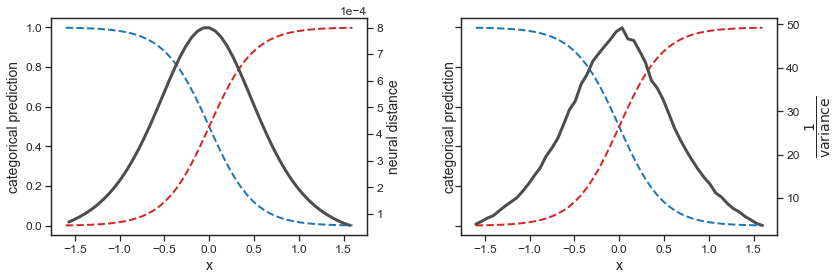

In [14]:
fh, axes = plt.subplots(1, 2, figsize=(13, 4), sharex=True, sharey=True)
ax1 = axes[0]
ax1.plot(x, p1x(x), c='tab:blue', ls='--', lw=2)
ax1.plot(x, 1-p1x(x), c='tab:red', ls='--', lw=2)
ax2 = ax1.twinx()
ax2.plot(.5*dx+x[:-1], dist, '-', c='0.3', lw=3, zorder=1)
ax1.set_xlabel('x')
ax1.set_ylabel('categorical prediction')
ax2.set_ylabel('neural distance')
ax2.ticklabel_format(scilimits=[-4,6])
ax1 = axes[1]
ax1.plot(x, p1x(x), c='tab:blue', ls='--', lw=2)
ax1.plot(x, 1-p1x(x), c='tab:red', ls='--', lw=2)
ax2 = ax1.twinx() 
ax2.plot(x, 1/np.var(xhat, axis=1), '-', c='0.3', lw=3)
ax1.set_xlabel('x')
ax1.set_ylabel('categorical prediction')
ax2.set_ylabel(r'$\dfrac{1}{\mathrm{variance}}$')
plt.subplots_adjust(wspace=0.3)  
plt.show()

fh.savefig('fig/gaussian1d_mlp.pdf', bbox_inches='tight')